In [1]:
import requests
import time
import pandas as pd
import numpy as np
import psycopg2
import sqlalchemy
from dotenv import load_dotenv
import os
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import missingno as msno
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
host = os.getenv('HOST')
port = os.getenv('PORT')
user = os.getenv('USER')
password = os.getenv('PASSWORD')
database= os.getenv('DATABASE')

In [3]:
# Verbindung zur Datenbank herstellen
connection = psycopg2.connect(host=host, port=port, database=database, user=user, password=password)
print("Verbindung zur Datenbank erfolgreich hergestellt.")

# Einen Cursor erstellen, um SQL-Abfragen auszuführen
cursor = connection.cursor()

# SQL SELECT-Abfrage
select_query = "SELECT * FROM value;"

# Abfrage ausführen
cursor.execute(select_query)

# Ergebnis abrufen
rows = cursor.fetchall()

# Ergebnis in ein Pandas DataFrame umwandeln
df = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])

# Cursor und Verbindung schließen
cursor.close()
connection.close()


Verbindung zur Datenbank erfolgreich hergestellt.


In [4]:
df_n = df[df["senseid_fk"]=="5c08379b1c28f9001a3f580c"]

In [5]:
df_n.sort_values(by="time", ascending=True, inplace=True)

C:\Users\conta\AppData\Local\Temp\ipykernel_27956\3766418188.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n.sort_values(by="time", ascending=True, inplace=True)


In [6]:
df_n.set_index('time', inplace=True)
df_n = df_n.drop(columns={"index","senseid_fk"},axis=1)

<AxesSubplot:xlabel='time'>

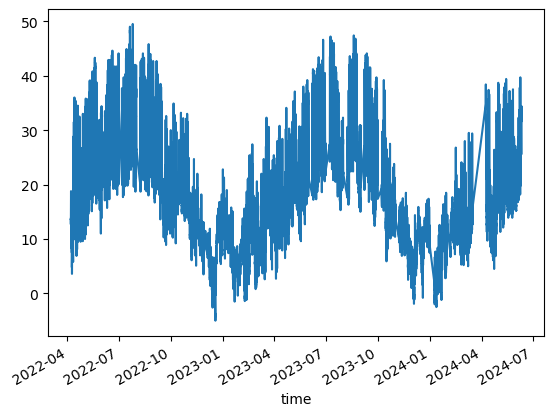

In [7]:
df_n.temperature.plot()

In [8]:
# Resample auf 10-Minuten-Rhythmus
df_n = df_n.resample('10T').mean()

# Fehlende Werte auffüllen (optional)
df_n.interpolate(method='time', inplace=True)

In [9]:
from statsmodels.tsa.stattools import adfuller

# Annahme: df_n ist Ihr DataFrame mit der Zeitreihe
# Hier nehmen wir an, dass die Temperatur in der Spalte 'temperature' gespeichert ist

# Führen Sie den ADF-Test durch
result = adfuller(df_n['temperature'])

# Ergebnisse ausgeben
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -11.568464503375674
p-value: 3.144185282439847e-21
Critical Values:
   1%: -3.4304071065869555
   5%: -2.861565240251998
   10%: -2.5667834344967817


In [10]:
df_n = df_n.drop(columns={'luftfeuchtigkeit','pm10', 'pm2_5'}, axis=1)

In [11]:
df_n

,temperature
time,
2022-04-07 00:00:00,13.666667
2022-04-07 00:10:00,13.500000
2022-04-07 00:20:00,13.450000
2022-04-07 00:30:00,13.266667
2022-04-07 00:40:00,13.200000
...,...
2024-06-10 16:30:00,26.500000
2024-06-10 16:40:00,26.400000
2024-06-10 16:50:00,26.200000


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Sicherstellen, dass eine GPU verfügbar ist
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [13]:
# Werte extrahieren
data = df_n['temperature'].values

In [14]:
# Daten skalieren
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.reshape(-1, 1)).flatten()

In [15]:
# Zeitreihen-Daten in 3D-Format umwandeln [samples, time_steps, features]
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 114536 
X, y = create_sequences(data_scaled, time_steps)

# In Torch-Tensoren konvertieren
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [16]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
    
    def forward(self, x, h_0=None, c_0=None):
        if h_0 is None or c_0 is None:
            h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
            c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, (h_0, c_0) = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out


In [24]:
# Modell initialisieren
input_size = 1  # Da wir nur die Temperatur als Merkmal haben
hidden_size = 50
num_layers = 2
output_size = 1
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Verlustfunktion und Optimierer definieren
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Modell trainieren
num_epochs = 25
batch_size = 64

In [25]:
for epoch in range(num_epochs):
    for i in range(0, len(X), batch_size):
        X_batch = X[i:i+batch_size]
        y_batch = y[i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = model(X_batch.unsqueeze(-1))
        loss = criterion(outputs, y_batch.unsqueeze(-1))
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Speichern des trainierten Modells
torch.save(model.state_dict(), 'lstm_model_trained_all_data.pth')

Epoch [1/25], Loss: 2.0671
Epoch [2/25], Loss: 2.0013
Epoch [3/25], Loss: 1.9352
Epoch [4/25], Loss: 1.8685
Epoch [5/25], Loss: 1.8005
Epoch [6/25], Loss: 1.7307
Epoch [7/25], Loss: 1.6581
Epoch [8/25], Loss: 1.5817
Epoch [9/25], Loss: 1.5005
Epoch [10/25], Loss: 1.4133
Epoch [11/25], Loss: 1.3186
Epoch [12/25], Loss: 1.2148
Epoch [13/25], Loss: 1.1003
Epoch [14/25], Loss: 0.9736
Epoch [15/25], Loss: 0.8336
Epoch [16/25], Loss: 0.6808
Epoch [17/25], Loss: 0.5184
Epoch [18/25], Loss: 0.3546
Epoch [19/25], Loss: 0.2057
Epoch [20/25], Loss: 0.0971
Epoch [21/25], Loss: 0.0583
Epoch [22/25], Loss: 0.1008
Epoch [23/25], Loss: 0.1789
Epoch [24/25], Loss: 0.2288
Epoch [25/25], Loss: 0.2364


<AxesSubplot:xlabel='time'>

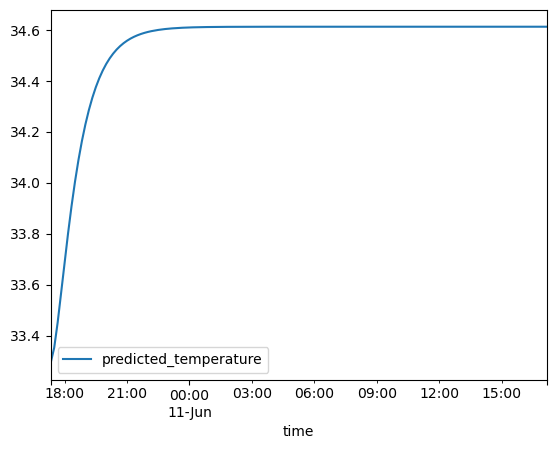

In [26]:
# Laden des trainierten Modells
loaded_model = LSTMModel(input_size, hidden_size, num_layers, output_size)
loaded_model.load_state_dict(torch.load('lstm_model_trained_all_data.pth'))
loaded_model.eval()

# Letzten 144 Werte aus dem DataFrame extrahieren und skalieren
last_144_values = df_n['temperature'].tail(144).values
last_144_scaled = scaler.transform(last_144_values.reshape(-1, 1)).flatten()

# Startpunkt: Die letzten 144 Werte aus dem DataFrame
current_seq = torch.tensor(last_144_scaled, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)

# Anfangswerte für die LSTM-Zelle auf demselben Gerät wie die Eingabedaten erstellen
h_0 = torch.zeros(num_layers, current_seq.size(0), hidden_size)
c_0 = torch.zeros(num_layers, current_seq.size(0), hidden_size)

# Vorhersagen der nächsten 144 Werte
predictions = []
for _ in range(144):
    with torch.no_grad():
        next_pred = loaded_model(current_seq, h_0, c_0)
        next_pred = next_pred.cpu().numpy().flatten()
        predictions.append(next_pred)
        next_value = torch.tensor(next_pred, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
        current_seq = torch.cat((current_seq[:, 1:, :], next_value), dim=1)

# Inverse Transformation der Vorhersagen
predictions = np.array(predictions).flatten()
predictions_original_scale = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

# Erstellen eines neuen DataFrames mit den Vorhersagen und den Zeitstempeln
last_time = df_n.index[-1]
prediction_times = [last_time + pd.Timedelta(minutes=10*(i+1)) for i in range(144)]
predictions_df = pd.DataFrame({
    'time': prediction_times,
    'predicted_temperature': predictions_original_scale
})

predictions_df.plot(x="time", y="predicted_temperature")


### Modell mit neuen Werten Feinstimmen

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Annahme: df_new ist Ihr DataFrame mit neuen Daten für einen Tag

# Laden des vorhandenen Modells
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
model.load_state_dict(torch.load('lstm_model_trained_all_data.pth'))

# Werte extrahieren
data_new = df_new['temperature'].values

# Skalierung der neuen Daten
scaler = StandardScaler()
data_scaled_new = scaler.fit_transform(data_new.reshape(-1, 1)).flatten()

# Zeitreihen-Daten in 3D-Format umwandeln [samples, time_steps, features]
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 7*24*6  # Eine Woche
X_new, y_new = create_sequences(data_scaled_new, time_steps)

# In Torch-Tensoren konvertieren
X_new = torch.tensor(X_new, dtype=torch.float32)
y_new = torch.tensor(y_new, dtype=torch.float32)

# Verlustfunktion und Optimierer definieren
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Modell trainieren mit neuen Daten
num_epochs = 10  # Anpassen je nach Bedarf
batch_size = 32

for epoch in range(num_epochs):
    for i in range(0, len(X_new), batch_size):
        X_batch = X_new[i:i+batch_size]
        y_batch = y_new[i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = model(X_batch.unsqueeze(-1))
        loss = criterion(outputs, y_batch.unsqueeze(-1))
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Speichern des feinabgestimmten Modells
torch.save(model.state_dict(), 'lstm_model_finetuned.pth')


NameError: name 'df_new' is not defined